In [1]:
import cobra
import pandas as pd
from cobra.flux_analysis import sample
import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_palette("coolwarm")

In [2]:
model_file = 'iCN900_09062018.json'
model = cobra.io.load_json_model(model_file)

## 1. Calculating flux distributions

In [3]:
# Sample the model:
import time
start = time.time()
s = sample(model, 1000)
end = time.time()
print(end-start)
s.to_csv('CDiff_sampled_1000.csv')

33.7690000534


In [4]:
# read in our sampled fluxes
s = pd.read_csv('CDiff_sampled_1000.csv',index_col=0)

5.90885167708
5.7971997569
3.32121092816


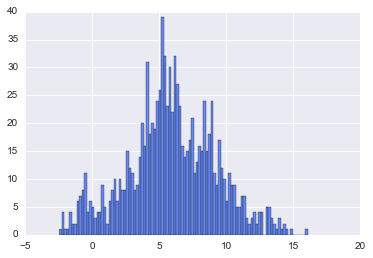

In [12]:
# show the flux distribution for Enolase ('ENO')
# Solution:
s['ENO'].hist(bins=100)
print(s['ENO'].mean())
print(s['ENO'].median())
print(s['ENO'].std())
plt.show()

In [13]:
sampled_flux_medians = s.median().clip_upper(10).clip_lower(-10)

In [14]:
from escher import Builder
b = Builder(model=model,map_name="e_coli_core.Core metabolism",reaction_data=sampled_flux_medians.to_dict())
b.display_in_notebook()

## 2. Simple integration of transcriptomic data

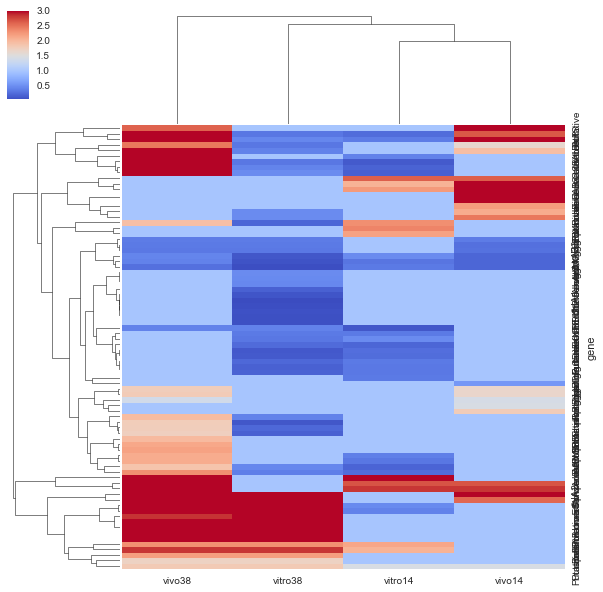

In [16]:
# gene expression data from:
# Adaptive Strategies and Pathogenesis of Clostridium difficile from In Vivo Transcriptomics by Janoir et al. I&I 2013
# doi: 10.1128/IAI.00515-13
data = pd.read_excel('expression.xlsx')
to_plot=data.copy()
to_plot.index=to_plot['gene']
to_plot = to_plot[['vitro14','vitro38','vivo14','vivo38']].clip_upper(3)
sns.clustermap(to_plot, cmap='coolwarm')

In [17]:
# note this data goes from vivo to vitro, so we need to convert for the reverse because we will be going from
# in-silico in vitro to invo cond:
data['to_adjust'] = data['vitro8']/data['vivo8']

In [18]:
data2 = data[data['to_adjust']!=1][['locus','to_adjust']]
data2

,locus,to_adjust
0,CD630_01120,2.29
1,CD630_01130,2.51
2,CD630_01140,2.15
4,CD630_01160,2.07
5,CD630_01170,2.44
6,CD630_01180,2.48
7,CD630_03340,0.43
34,CD630_19080,0.25
35,CD630_19090,0.32
36,CD630_19100,0.18


In [19]:
# adjust a gene (and its rxns) in one direction or another
def constrain_gene_flux(model, gene,factor):
    if gene in model.genes:
        reactions = model.genes.get_by_id(gene).reactions
        reaction_ids = [r.id for r in reactions]
        #print(s[reaction_ids].median())
        constrain = s[reaction_ids].median()
        for r in reactions:
            to_constrain = constrain.ix[r.id]*factor
            if to_constrain<0:
                r.lower_bound=to_constrain
            else:
                r.upper_bound=to_constrain
            print('adjusting %s (%s) from %s to %s'%(r.id, gene, to_constrain/factor, to_constrain))
    else:
        print('%s not in model'%gene)
    return model

In [20]:
sol=model.optimize()
print(sol.objective_value)

0.21028281212


In [21]:
for i in data2.index:
    gene = data2.loc[i,'locus']
    factor = data2.loc[i,'to_adjust']
    model = constrain_gene_flux(model, gene, factor)

adjusting PBUTT (CD630_01120) from -1.5722492168e-13 to -3.60045070646e-13
adjusting PTA2E (CD630_01120) from 0.729048997255 to 1.66952220371
adjusting PIBT (CD630_01120) from 0.620037105502 to 1.4198849716
adjusting BUTKr (CD630_01130) from -1.57430740127e-13 to -3.95151157719e-13
CD630_01140 not in model
adjusting VOR2bE (CD630_01160) from 0.051237852023 to 0.106062353688
CD630_01170 not in model
adjusting POR_syn (CD630_01180) from 0.166900249559 to 0.413912618905
adjusting GLYCR (CD630_03340) from 0.0211204261119 to 0.0090817832281
adjusting ALCD2x (CD630_03340) from -0.307854966341 to -0.132377635526
adjusting BNOCA (CD630_03340) from 0.0 to 0.0
adjusting IBHH (CD630_03340) from 0.0793164600037 to 0.0341060778016
adjusting CHOLD2 (CD630_03340) from 0.0 to 0.0
adjusting GLYCR2 (CD630_03340) from 0.0189841721942 to 0.00816319404351
adjusting BTS_nadph (CD630_03340) from 0.0 to 0.0
adjusting BTCOARx (CD630_03340) from 0.0 to 0.0
adjusting ACALD (CD630_03340) from 2.14625628683 to 0.9

In [22]:
import time
start = time.time()
s2 = sample(model, 1000)
end = time.time()
print(end-start)
s2.to_csv('CDiff_adjust_sampled_1000.csv')

33.5950000286


In [24]:
s2 = pd.read_csv('CDiff_adjust_sampled_1000.csv',index_col=0)

## 3. Comparing sampled flux states:

In [25]:
# use Kolmogorov-Smirnov statistic to check overlap of two distributions
from scipy import stats
import numpy as np

In [26]:
res = []
for r in model.reactions:
    p1 = s[r.id]
    p2 = s2[r.id]
    
    p1median = p1.median()
    p1mean = p1.mean()
    p1std = p1.std()
    
    p2median = p2.median()
    p2mean = p2.mean()
    p2std = p2.std()
    
    stat, pval = stats.ks_2samp(p1,p2)
      
    
    res.append({'reaction':r.id, 'p1median':p1median,'p1mean':p1mean, 'p1std':p1std, 
                'p2median':p2median,'p2mean':p2mean,'p2std':p2std, 'pval':pval})
res = pd.DataFrame(res)

In [28]:
res.to_csv('flux_differences.csv')

In [29]:
res = pd.read_csv('flux_differences.csv', index_col=0)

In [30]:
# Find significant changes and plot them on an Escher map:

#Soution:
res['delta'] = abs(res['p1median']-res['p2median']) # absolute flux difference
#res['delta'] = res['p1median']/res['p2median'] # relative flux difference
sig = res
sig = sig[(sig['pval']<0.05)&(sig['delta']>1)]

In [31]:
sig.sort_values(['delta','pval'])

,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction,delta
340,-5.423641,-5.117853,2.946544,-4.159821,-4.103294,2.623117,1.011598e-13,NRRH,1.014560
430,14.914648,14.652570,1.181766,13.645845,13.635425,1.324809,3.007157e-74,RPI,1.017144
283,4.255862,3.049834,3.669442,3.098937,2.030198,3.812661,8.591195e-20,ACS,1.019637
548,1.881245,1.066412,1.781175,2.132321,2.089747,1.295267,1.118527e-32,ADNUC,1.023335
807,-3.351477,-3.154276,1.233954,-2.334024,-2.129918,0.788689,4.641082e-76,PCFPT,1.024358
277,10.882633,10.246217,6.584772,9.565501,9.216794,4.209415,6.197280e-06,G1PP,1.029423
267,11.000460,10.362847,6.587720,9.678597,9.330187,4.209209,6.197280e-06,PGCM,1.032660
145,0.754516,0.603515,0.579060,1.764573,1.673365,0.944419,2.440498e-109,ICDHx,1.069850
372,2.270779,1.826215,1.990769,3.545798,2.947546,3.233039,3.333801e-32,FTHFLi,1.121331
1180,2.915437,2.762100,1.060579,1.653399,1.605825,0.753055,1.588149e-83,ADD,1.156275


In [32]:
from escher import Builder
var = 'delta'
fluxes = sig[['reaction',var]]
fluxes.index=fluxes['reaction']
b = Builder(model=model,map_json="CDiffCentralCarbon.json",reaction_data=fluxes[var].to_dict())
b.display_in_notebook()